## GMM Estimation of Model Parameters of Expectation Formation

- This notebook includes functions that estimate the parameter of rigidity for different models
- It allows for flexible choices of moments to be used, forecast error, disagreement, and uncertainty, etc. 
- It includes 
  - A general function that implements the estimation using the minimum distance algorithm. 
  - Model-specific functions that take real-time data and process parameters as inputs and produces forecasts and moments as outputs. It is model-specific because different models of expectation formation bring about different forecasts. 
  - Auxiliary functions that compute the moments as well as the difference of data and model prediction, which will be used as inputs for GMM estimator. 

### 1. Estimation algorithms 

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import AR
import copy as cp 
from scipy.stats import bernoulli

In [2]:
# a general-purpose estimating function of the parameter
def Estimator(obj_func,
              para_guess,
              method='CG'):
    """
    Inputs
    ------
    - moments: a function of the rigidity model parameter  
    - method: method of optimization 
    
    Outputs
    -------
    - parameter: an array of estimated parameter
    """
    
    parameter = minimize(obj_func,
                         x0 = para_guess,
                         method=method,
                         options={'disp': True})['x']
    return parameter 

In [3]:
# a function that prepares moment conditions. So far the loss being simply the norm of the difference
def PrepMom(model_moments,
            data_moments):
    """
    Inputs
    -----
    model_moments: an array of moments from a certain model, i.e. forecast error, disagreement and uncertainty. 
    data_moments: an array of moments computed from the survey data
    
    Outputs
    ------
    diff: the Euclidean distance of two arrays of data and model 
    
    """
    diff = np.linalg.norm(model_moments - data_moments)
    return diff

In [4]:
## auxiliary functions 
def hstepvar(h,sigma,rho):
    return sum([ rho**(2*i)*sigma**2 for i in range(h)] )

np.random.seed(12345)
def hstepfe(h,sigma,rho):
    return sum([rho**i*(np.random.randn(1)*sigma)*np.random.randn(h)[i] for i in range(h)])
## This is not correct. 


def ForecastPlot(test):
    x = plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label=val)
        plt.legend(loc=1)
    return x
        
def ForecastPlotDiag(test,data):
    x = plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label='model:'+ val)
        plt.plot(np.array(data[val]),label='data:'+ val)
        plt.legend(loc=1)
    return x
        
### AR1 simulator 
def AR1_simulator(rho,sigma,nobs):
    xxx = np.zeros(nobs+1)
    shocks = np.random.randn(nobs+1)*sigma
    xxx[0] = 0 
    for i in range(nobs):
        xxx[i+1] = rho*xxx[i] + shocks[i+1]
    return xxx[1:]

In [5]:
## some process parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

In [6]:
### create fake real-time data 
xxx = AR1_simulator(rho,sigma,100)

In [7]:
## Rational Expectation (RE) class 
class RationalExpectation:
    def __init__(self,
                 real_time,
                 horizon=1,
                 process_para = process_para,
                 exp_para = {},
                 moments=['Forecast','Disg','Var']):
        self.real_time = real_time
        self.horizon = horizon
        self.process_para = process_para
        self.moments = moments
    
    def GetRealization(self,realized_series):
        self.realized = realized_series
        
    def SimulateRealization(self):
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[i+h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] + cum_shock
        self.realized = realized        
        
    def Forecaster(self):
        ## parameters
        n = len(self.real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        
        ## parameters
        max_back = self.max_back
        real_time = self.real_time
        horizon = self.horizon
        
        ## forecast moments 
        Disg =np.zeros(n)
        infoset = real_time
        nowcast = infoset
        forecast = rho**horizon*nowcast
        Var = hstepvar(horizon,sigma,rho)* np.ones(n)
        FE = forecast - self.realized ## forecast errors depend on realized shocks 
        self.forecast_moments = {"Forecast":forecast,
                                 "FE":FE,
                                 "Disg":Disg,
                                 "Var":Var}
        return self.forecast_moments

In [8]:
### create a RE instance 
#FE_instance = RationalExpectation(real_time = xxx)

In [9]:
### simulate a realized series 
#FE_instance.SimulateRealization()

In [10]:
### forecster
#fe_moms = FE_instance.Forecaster()
#ForecastPlot(fe_moms)

In [11]:
## expectation parameters 
SE_para_default = {'lambda':0.8}

In [108]:
## Sticky Expectation(SE) class 
class StickyExpectation:
    def __init__(self,
                 real_time,
                 history,
                 horizon=1,
                 process_para = process_para,
                 exp_para = SE_para_default,
                 max_back =10,
                 moments = ['Forecast','Disg','Var']):
        self.history = history
        self.real_time = real_time
        self.n = len(real_time)
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
        self.max_back = max_back
        self.data_moms_dct ={}
        self.para_est = {}
        self.moments = moments
        
    def GetRealization(self,
                       realized_series):
        self.realized = realized_series   
    
    def SimulateRealization(self):
        n = self.n
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[i+h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] + cum_shock
        self.realized = realized
        
    def Forecaster(self):
        ## inputs 
        real_time = self.real_time
        n = len(real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        lbd = self.exp_para['lambda']
        max_back = self.max_back
        horizon = self.horizon      
        
        ## forecast moments 
        #FE = sum( [lbd*(1-lbd)**tau*hstepfe(horizon+tau,sigma,rho) for tau in range(max_back)] ) * np.ones(n) # a function of lambda, real-time and process_para 
        Var = sum([ lbd*(1-lbd)**tau*hstepvar(horizon+tau,sigma,rho) for tau in range(max_back)] ) * np.ones(n)  
        # same as above 
        nowcast = sum([ lbd*(1-lbd)**tau*(rho**tau)*np.roll(real_time,tau) for tau in range(max_back)]) 
        # the first tau needs to be burned
        forecast = rho**horizon*nowcast
        FE = forecast - self.realized
        Disg =  sum([ lbd*(1-lbd)**tau*(rho**(tau+horizon)*np.roll(real_time,tau)-forecast)**2 for tau in range(max_back)] )
        self.forecast_moments = {"Forecast":forecast, 
                "FE":FE,
                "Disg":Disg,
                "Var":Var}
        return self.forecast_moments
    
    def ForecasterbySim(self,
                        n_sim = 100):
        ## inputs 
        real_time = self.real_time
        history  = self.history 
        n = len(real_time)
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        lbd = self.exp_para['lambda']
        max_back = self.max_back
        horizon = self.horizon 
        n_burn = len(history) - n
        n_history = n + n_burn  # of course equal to len(history)
    
        
        ## simulation
        update_or_not = bernoulli.rvs(p = lbd,
                                      size=[n_sim,n_history])
        most_recent = np.empty_like(update_or_not)
        nowcasts_rough = np.empty_like(update_or_not)
        Vars_rough = np.empty_like(update_or_not)
        ## look for the most recent updates for each point of time  ## something is wrong so far.
        for i in range(most_recent.shape[0]):
            #print(i)
            for j in range(most_recent.shape[1]):
                #print(j)
                if any([x for x in range(j) if update_or_not[i,j-x] == True]):
                    most_recent[i,j] = min([x for x in range(j) if update_or_not[i,j-x] == True])
                else:
                    #print(most_recent_for_ij)
                    most_recent[i,j] = j
                #print(history[j-most_recent[i,j]])
                nowcasts_rough[i,j] = history[j-most_recent[i,j]]*(rho**most_recent[i,j])
                #print(history[j-most_recent[i,j]]*(rho**most_recent[i,j]))
                #nowcasts_rough = sum([np.multiply(xx_stack,np.roll(update_or_not,back)) for back in range(n_burn)]) 
                Vars_rough[i,j] = hstepvar(most_recent[i,j]+horizon,rho,sigma)
                
        nowcasts = nowcasts_rough[:,n_burn:]
        forecasts = rho**horizon*nowcasts
        Vars = Vars_rough[:,n_burn:]
        
        ## compuate population moments
        
        forecasts_mean = np.mean(forecasts,axis=0)
        forecasts_var = np.var(forecasts,axis=0)
        FEs_mean = forecasts_mean - self.realized
        Vars_mean = np.mean(Vars,axis=0) ## need to change 
        
        self.forecast_moments_sim = {"Forecast":forecasts_mean, 
                "FE":FEs_mean,
                "Disg":forecasts_var,
                "Var":Vars_mean}
        return self.forecast_moments_sim

    
    ## a function estimating SE model parameter only 
    def SE_EstObjfunc(self,lbd):
        """
        input
        -----
        lbd: the parameter of SE model to be estimated
        
        output
        -----
        the objective function to minmize
        """
        moments = self.moments
        SE_para = {"lambda":lbd}
        self.exp_para = SE_para  # give the new lambda
        data_moms_dct = self.data_moms_dct
        
        SE_moms_dct = self.Forecaster()
        SE_moms = np.array([SE_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(SE_moms,data_moms)
        return obj_func 
    
    ## feeds the instance with data moments dictionary 
    def GetDataMoments(self,
                       data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    ## invoke the estimator 
    def ParaEstimate(self,
                     para_guess=0.2,
                     method='CG'):
        self.para_est = Estimator(self.SE_EstObjfunc,
                                  para_guess=para_guess,
                                  method='CG')
        
    def ForecastPlot(self):
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments[val],label=val)
            plt.legend(loc=1)
            
    def ForecastPlotDiag(self):
        exp_para_est_dct = {'lambda':self.para_est[0]}
        new_instance = cp.deepcopy(self)
        new_instance.exp_para = exp_para_est_dct
        self.forecast_moments_est = new_instance.Forecaster()
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments_est[val],'r-',label='model:'+ val)
            plt.plot(np.array(self.data_moms_dct[val]),'*',label='data:'+ val)
            plt.legend(loc=1)

In [109]:
xx_history = AR1_simulator(rho,sigma,100)
xx_real_time = xx_history[10:]

### create a SE instance using fake real time data 
SE_instance = StickyExpectation(real_time = xx_real_time,
                                history = xx_history)
SE_instance.SimulateRealization()

In [110]:
### simulate a realized series 
mom_dct =  SE_instance.Forecaster()
mom_sim_dct = SE_instance.ForecasterbySim(n_sim=100)

-0.15438142406244457
-0.14666235285932233
-0.24050613179992036
-0.22848082520992433
-0.187316556196049
-0.08683729164742436
-0.08249542706505314
-0.10228717008046795
-0.09717281157644454
-0.10014717317873187
-0.04680174541669021
-0.09017853561992487
-0.11377070935035077
-0.05953831617505307
-0.05656140036630041
-0.05373333034798539
-0.023225317349837904
0.09018380805860003
0.1443141751613426
0.24209242213125312
0.27738290823960976
0.2635137628276293
0.3309197269002693
0.29753577728192265
0.1515525021956921
0.24544601602233201
0.09426718616190313
0.18234200560792066
0.23802888561657648
0.19067599904935287
0.08995036761698613
0.08545284923613682
0.051403814104667336
-0.007335564222642477
-0.006968786011510353
-0.09203967942818914
-0.10384955192901053
-0.12241744046067006
-0.17929264844677553
-0.13986931968009597
-0.007874538507946782
-0.09745931960420591
-0.08603668144169953
0.02595257901880227
0.024654950067862155
0.023422202564469047
0.15946658261983213
-0.0921524377927273
-0.164255288

-0.17795072838624654
-0.1659125635130212
-0.10228717008046795
-0.09717281157644454
-0.10014717317873187
-0.09513981451979527
-0.09017853561992487
-0.11377070935035077
-0.05953831617505307
-0.09693121337784902
-0.09208465270895656
-0.023225317349837904
0.09018380805860003
0.08567461765567003
0.24209242213125312
0.27738290823960976
0.3701540355909113
0.3309197269002693
0.29753577728192265
0.2826589884178265
0.24544601602233201
0.09426718616190313
0.18234200560792066
0.23802888561657648
0.19067599904935287
0.18114219909688523
0.041451745041725246
0.051403814104667336
-0.007335564222642477
-0.08608563856391824
-0.08178135663572232
-0.10384955192901053
-0.09865707433256
-0.17929264844677553
-0.17032801602443676
-0.1618116152232149
-0.09745931960420591
-0.08603668144169953
0.02595257901880227
-0.028471319468724776
0.024779061952653485
0.15946658261983213
-0.0921524377927273
-0.16425528888841923
-0.19572348991241517
-0.07903304142094744
-0.07508138934990007
0.1280078781913223
0.33279504258631

0.24295479025397893
0.23080705074127997
0.10537215766233583
0.17027806064311188
0.16176415761095628
0.15367594973040846
-0.2515677031047162
-0.2947691314892987
-0.35380684958154557
-0.17621096839339898
-0.18050770921177378
-0.17148232375118508
-0.16290820756362584
-0.16112511456960726
-0.12516778199156828
-0.072499014175361
-0.056404363114164316
-0.0535841449584561
-0.030438712452933114
-0.15259529206758385
-0.30577171180410834
-0.29048312621390293
-0.05715013883534165
0.13711936602101793
0.09639949272591118
0.09164361880331309
0.052276801263833134
-0.14743066646748995
0.0014681460658889922
0.1635323805870672
0.15535576155771383
0.14758797347982816
0.07614641194456671
0.22467920096224459
0.27772161645236715
0.3019659589650169
0.3480998758789161
0.2247291051918818
0.20951934653483248
0.27716252445844464
0.2633043982355224
-0.15438142406244457
-0.14666235285932233
-0.24050613179992036
-0.22848082520992433
-0.187316556196049
-0.08683729164742436
-0.1659125635130212
-0.10228717008046795
-0

-0.11377070935035077
-0.05953831617505307
-0.09693121337784902
-0.1338016034206019
-0.023225317349837904
0.09018380805860003
0.08567461765567003
0.24209242213125312
0.27738290823960976
0.3701540355909113
0.35164633381136573
0.29753577728192265
0.1515525021956921
0.24544601602233201
0.09426718616190313
0.18234200560792066
0.23802888561657648
0.19067599904935287
0.08995036761698613
0.041451745041725246
0.051403814104667336
0.048833623399433965
0.04639194222946227
-0.09203967942818914
-0.10384955192901053
-0.12241744046067006
-0.11629656843763655
-0.11048174001575473
-0.007874538507946782
-0.007480811582549443
-0.08603668144169953
0.02595257901880227
-0.028471319468724776
0.024779061952653485
0.15946658261983213
-0.0921524377927273
-0.16425528888841923
-0.19572348991241517
-0.1859373154167944
-0.17664044964595468
0.1280078781913223
0.12160748428175619
0.395817542216794
0.3760266651059543
0.3572253318506566
0.389737970571193
0.37025107204263336
0.3517385184405017
0.23787381499050814
0.1053

0.17027806064311188
-0.08294577328840047
-0.15230338923650544
-0.14468821977468016
-0.2947691314892987
-0.35380684958154557
-0.33611650710246826
-0.18050770921177378
-0.2699845445337312
-0.25648531730704466
-0.16112511456960726
-0.12516778199156828
-0.072499014175361
-0.056404363114164316
-0.0535841449584561
-0.050904937710533296
-0.15259529206758385
-0.14496552746420466
-0.13771725109099442
-0.1308313885364447
0.13711936602101793
0.09639949272591118
0.09157951808961562
0.052276801263833134
-0.14743066646748995
0.0014681460658889922
0.1635323805870672
0.06644131529866268
0.07781691620900535
0.07392607039855509
0.22467920096224459
0.27772161645236715
0.3019659589650169
0.3480998758789161
0.3306948820849703
0.20951934653483248
0.27716252445844464
0.2620950903820882
-0.15438142406244457
-0.14666235285932233
-0.24050613179992036
-0.198531918538139
-0.187316556196049
-0.08683729164742436
-0.1659125635130212
-0.10228717008046795
-0.20537835011693145
-0.10014717317873187
-0.04680174541669021


-0.17929264844677553
-0.13986931968009597
-0.13287585369609117
-0.09745931960420591
-0.08603668144169953
0.02595257901880227
-0.028471319468724776
0.024779061952653485
0.15946658261983213
-0.0921524377927273
-0.16425528888841923
-0.19572348991241517
-0.07903304142094744
0.09635684994161699
0.1280078781913223
0.3327950425863195
0.395817542216794
0.3702680256765596
0.31478326471715584
0.389737970571193
0.37025107204263336
0.24295479025397893
0.23787381499050814
0.2259801242409827
0.17027806064311188
-0.08294577328840047
-0.15230338923650544
-0.2515677031047162
-0.2947691314892987
-0.28003067491483374
-0.17621096839339898
-0.18050770921177378
-0.2699845445337312
-0.2784592620119838
-0.16112511456960726
-0.12516778199156828
-0.072499014175361
-0.06887406346659294
-0.07626820326890002
-0.030438712452933114
-0.15259529206758385
-0.30577171180410834
-0.08840019628622467
-0.05715013883534165
0.13711936602101793
0.09639949272591118
0.09157951808961562
0.052276801263833134
-0.14743066646748995
-

0.14391859081439848
-0.19572348991241517
-0.07903304142094744
-0.07508138934990007
0.1280078781913223
0.3327950425863195
0.395817542216794
0.3702680256765596
0.31478326471715584
0.389737970571193
0.37025107204263336
0.24295479025397893
0.23787381499050814
0.10537215766233583
0.17027806064311188
-0.08294577328840047
-0.15230338923650544
-0.2515677031047162
-0.2947691314892987
-0.35380684958154557
-0.33611650710246826
-0.18050770921177378
-0.2699845445337312
-0.25648531730704466
-0.16112511456960726
-0.12516778199156828
-0.072499014175361
-0.056404363114164316
-0.07626820326890002
-0.030438712452933114
-0.15259529206758385
-0.30577171180410834
-0.29048312621390293
-0.2759589699032078
0.13711936602101793
0.09639949272591118
0.09164361880331309
0.052276801263833134
-0.14743066646748995
-0.14005913314411544
0.1635323805870672
0.15535576155771383
0.07781691620900535
0.07614641194456671
0.22467920096224459
0.27772161645236715
0.3019659589650169
0.28686766101676603
0.2247291051918818
0.2095193

-0.14743066646748995
0.0014681460658889922
0.1635323805870672
0.06644131529866268
0.07781691620900535
0.07614641194456671
0.22467920096224459
0.27772161645236715
0.3019659589650169
0.3480998758789161
0.2247291051918818
0.20951934653483248
0.27716252445844464
0.2620950903820882
-0.15438142406244457
-0.14666235285932233
-0.24050613179992036
-0.198531918538139
-0.18860532261123206
-0.08683729164742436
-0.1659125635130212
-0.10228717008046795
-0.20537835011693145
-0.10014717317873187
-0.04680174541669021
-0.0444616581458557
-0.11377070935035077
-0.05953831617505307
-0.09693121337784902
-0.1338016034206019
-0.023225317349837904
0.09018380805860003
0.08567461765567003
0.24209242213125312
0.27738290823960976
0.2635137628276293
0.3309197269002693
0.3143737405552558
0.298655053527493
0.24544601602233201
0.09426718616190313
0.18234200560792066
0.23802888561657648
0.19067599904935287
0.18114219909688523
0.041451745041725246
0.051403814104667336
-0.007335564222642477
-0.006968786011510353
-0.09203

0.17027806064311188
-0.08294577328840047
-0.07879848462398044
-0.2515677031047162
-0.2389893179494804
-0.35380684958154557
-0.17621096839339898
-0.18050770921177378
-0.2699845445337312
-0.25648531730704466
-0.16112511456960726
-0.12516778199156828
-0.072499014175361
-0.056404363114164316
-0.07626820326890002
-0.030438712452933114
-0.15259529206758385
-0.30577171180410834
-0.08840019628622467
-0.05715013883534165
0.13711936602101793
0.13026339771996703
0.09164361880331309
0.052276801263833134
-0.14743066646748995
-0.14005913314411544
0.1635323805870672
0.06644131529866268
0.07781691620900535
0.07614641194456671
0.22467920096224459
0.27772161645236715
0.3019659589650169
0.3480998758789161
0.2247291051918818
0.20951934653483248
0.27716252445844464
0.2633043982355224
-0.15438142406244457
-0.14666235285932233
-0.13081453955224456
-0.12427381257463233
-0.1180601219459007
-0.08683729164742436
-0.08249542706505314
-0.10228717008046795
-0.20537835011693145
-0.10014717317873187
-0.04680174541669

0.18114219909688523
0.17208508914204096
0.051403814104667336
0.048833623399433965
-0.08608563856391824
-0.09203967942818914
-0.08743769545677968
-0.12241744046067006
-0.11629656843763655
-0.11048174001575473
-0.007874538507946782
-0.007480811582549443
-0.08603668144169953
0.02595257901880227
0.024654950067862155
0.024779061952653485
0.15946658261983213
-0.0921524377927273
-0.08754481590309093
-0.08316757510793639
-0.07903304142094744
0.09635684994161699
0.1280078781913223
0.3327950425863195
0.395817542216794
0.3702680256765596
0.31478326471715584
0.389737970571193
0.34011700105612386
0.24295479025397893
0.23787381499050814
0.2259801242409827
0.17027806064311188
-0.08294577328840047
-0.15230338923650544
-0.2515677031047162
-0.2389893179494804
-0.35380684958154557
-0.17621096839339898
-0.18050770921177378
-0.2699845445337312
-0.2784592620119838
-0.16112511456960726
-0.12516778199156828
-0.072499014175361
-0.056404363114164316
-0.07626820326890002
-0.030438712452933114
-0.1525952920675838

-0.2947691314892987
-0.35380684958154557
-0.17621096839339898
-0.18050770921177378
-0.2699845445337312
-0.2784592620119838
-0.16112511456960726
-0.1530688588411269
-0.072499014175361
-0.056404363114164316
-0.0535841449584561
-0.030438712452933114
-0.15259529206758385
-0.30577171180410834
-0.29048312621390293
-0.05715013883534165
0.13711936602101793
0.09639949272591118
0.09164361880331309
0.052276801263833134
-0.14743066646748995
0.0014681460658889922
0.1635323805870672
0.15535576155771383
0.14758797347982816
0.07614641194456671
0.07233909134733837
0.27772161645236715
0.26383553562974876
0.25064375884826134
0.23811157090584825
0.20951934653483248
0.19904337920809084
0.2620950903820882
-0.15438142406244457
-0.14666235285932233
-0.1393292352163562
-0.198531918538139
-0.187316556196049
-0.08683729164742436
-0.1659125635130212
-0.10228717008046795
-0.20537835011693145
-0.10014717317873187
-0.04680174541669021
-0.09017853561992487
-0.11377070935035077
-0.05953831617505307
-0.0969312133778490

-0.05953831617505307
-0.09693121337784902
-0.1338016034206019
-0.023225317349837904
0.09018380805860003
0.08567461765567003
0.08139088677288653
0.27738290823960976
0.2635137628276293
0.3309197269002693
0.29753577728192265
0.1515525021956921
0.1439748770859075
0.09426718616190313
0.18234200560792066
0.17322490532752463
0.1645636600611484
0.08995036761698613
0.041451745041725246
0.051403814104667336
-0.007335564222642477
-0.006968786011510353
-0.09203967942818914
-0.08743769545677968
-0.12241744046067006
-0.17929264844677553
-0.13986931968009597
-0.007874538507946782
-0.09745931960420591
-0.08603668144169953
0.02595257901880227
-0.028471319468724776
0.024779061952653485
0.15946658261983213
-0.0921524377927273
-0.16425528888841923
-0.15604252444399827
-0.14824039822179835
0.09635684994161699
0.1280078781913223
0.3327950425863195
0.395817542216794
0.3702680256765596
0.3517546243927316
0.389737970571193
0.37025107204263336
0.24295479025397893
0.23787381499050814
0.2259801242409827
0.1702780

0.06644131529866268
0.07781691620900535
0.07614641194456671
0.07233909134733837
0.06872213677997145
0.3019659589650169
0.3480998758789161
0.2247291051918818
0.20951934653483248
0.19904337920809084
0.2620950903820882
-0.15438142406244457
-0.14666235285932233
-0.13081453955224456
-0.198531918538139
-0.187316556196049
-0.08683729164742436
-0.1659125635130212
-0.10228717008046795
-0.20537835011693145
-0.19510943261108488
-0.04680174541669021
-0.09017853561992487
-0.11377070935035077
-0.05953831617505307
-0.05656140036630041
-0.1338016034206019
-0.023225317349837904
0.09018380805860003
0.1443141751613426
0.24209242213125312
0.27738290823960976
0.2635137628276293
0.3309197269002693
0.29753577728192265
0.2826589884178265
0.26852603899693517
0.2550997370470884
0.18234200560792066
0.23802888561657648
0.19067599904935287
0.08995036761698613
0.08545284923613682
0.051403814104667336
0.048833623399433965
-0.08608563856391824
-0.09203967942818914
-0.10384955192901053
-0.12241744046067006
-0.17929264

-0.15438142406244457
-0.14666235285932233
-0.1393292352163562
-0.1323627734555384
-0.187316556196049
-0.17795072838624654
-0.1659125635130212
-0.10228717008046795
-0.20537835011693145
-0.10014717317873187
-0.04680174541669021
-0.09017853561992487
-0.11377070935035077
-0.05953831617505307
-0.09693121337784902
-0.09208465270895656
-0.023225317349837904
0.09018380805860003
0.1443141751613426
0.13709846640327547
0.27738290823960976
0.3701540355909113
0.3309197269002693
0.29753577728192265
0.1515525021956921
0.24544601602233201
0.09426718616190313
0.18234200560792066
0.23802888561657648
0.19067599904935287
0.08995036761698613
0.041451745041725246
0.039379157789638984
0.03741019990015703
0.03553968990514918
-0.09203967942818914
-0.10384955192901053
-0.09865707433256
-0.17929264844677553
-0.13986931968009597
-0.007874538507946782
-0.09745931960420591
-0.08603668144169953
-0.08173484736961455
-0.028471319468724776
0.024779061952653485
0.15946658261983213
0.15149325348884052
0.14391859081439848

-0.05953831617505307
-0.09693121337784902
-0.1338016034206019
-0.023225317349837904
0.09018380805860003
0.1443141751613426
0.13709846640327547
0.27738290823960976
0.3701540355909113
0.3309197269002693
0.29753577728192265
0.1515525021956921
0.24544601602233201
0.09426718616190313
0.18234200560792066
0.23802888561657648
0.19067599904935287
0.08995036761698613
0.041451745041725246
0.051403814104667336
0.048833623399433965
-0.08608563856391824
-0.08178135663572232
-0.10384955192901053
-0.12241744046067006
-0.17929264844677553
-0.17032801602443676
-0.007874538507946782
-0.09745931960420591
-0.08603668144169953
0.02595257901880227
-0.028471319468724776
0.024779061952653485
0.15946658261983213
-0.0921524377927273
-0.16425528888841923
-0.19572348991241517
-0.07903304142094744
0.09635684994161699
0.1280078781913223
0.3327950425863195
0.395817542216794
0.3702680256765596
0.31478326471715584
0.389737970571193
0.34011700105612386
0.24295479025397893
0.23080705074127997
0.21926669820421596
0.170278

In [111]:
mom_sim_dct

{'Forecast': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 'FE': array([ 0.17509873,  0.10299172,  0.23045916,  0.02255733,  0.13324931,
         0.12952277,  0.10599978, -0.08925924, -0.13037979, -0.2847549 ,
        -0.24226927, -0.44621972, -0.20983565, -0.21700602, -0.26057581,
        -0.15898446, -0.16549998, -0.28577649, -0.33037558, -0.12577147,
        -0.06674517,  0.05257835, -0.2818204 , -0.08755382,  0.20196587,
        -0.01064903,  0.16558621,  0.07665307,  0.19957668,  0.21571661,
        -0.05516193,  0.04416879, -0.10324857, -0.10601157,  0.05970903,
        -0.02177446, -0.16498382, -0.0134339 ,  0.11755894,  

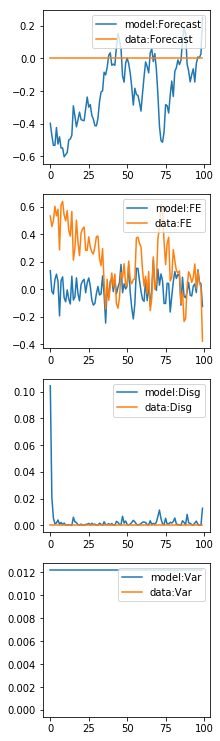

In [59]:
#mom_sim_and_pop = ForecastPlotDiag(mom_dct,mom_sim_dct)

In [16]:
### fake data moments 
data_moms_dct_fake = SE_instance.Forecaster()

In [17]:
#SE_instance.ForecastPlot()

In [18]:
### feed the data moments
#SE_instance.GetDataMoments(data_moms_dct_fake)

In [19]:
### invokes the estimation 
#SE_instance.ParaEstimate()
#SE_instance.para_est

In [20]:
#SE_instance.ForecastPlotDiag()

In [21]:
NI_para_default = {'sigma_pb':0.2,
                  'sigma_pr':0.1,
                  'var_init':0.1}

In [22]:
## Noisy Information(NI) class 

class NoisyInformation:
    def __init__(self,
                 real_time,
                 horizon=1,
                 process_para = process_para, 
                 exp_para = NI_para_default,
                 moments = ['Forecast','Disg','Var']):
        self.real_time = real_time
        self.n = len(real_time)
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
        self.data_moms_dct ={}
        self.para_est = {}
        self.moments = moments
    
        
    def GetRealization(self,
                       realized_series):
        self.realized = realized_series   
    
    def SimulateRealization(self):
        n = self.n
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[i+h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] + cum_shock
        self.realized = realized
        
    def SimulateSignals(self):
        n = self.n
        sigma_pb = self.exp_para['sigma_pb']
        sigma_pr =self.exp_para['sigma_pr']
        s_pb = self.real_time+sigma_pb*np.random.randn(n)
        s_pr = self.real_time+sigma_pr*np.random.randn(n)
        self.signals = np.asmatrix(np.array([s_pb,s_pr]))
        
    # a function that generates population moments according to NI     
    def Forecaster(self):
        ## inputs 
        real_time = self.real_time
        n = self.n
        rho  = self.process_para['rho']
        sigma = self.process_para['sigma']
        sigma_pb = self.exp_para['sigma_pb']
        sigma_pr =self.exp_para['sigma_pr']
        var_init = self.exp_para['var_init']
        sigma_v = np.asmatrix([[sigma_pb**2,0],[0,sigma_pr**2]])
        horizon = self.horizon      
        s = self.signals
        nb_s=len(self.signals) ## # of signals 
        H = np.asmatrix ([[1,1]]).T
        Pkalman = np.zeros([n,nb_s])
        nowcast = np.zeros(n)
        nowcast[0] = real_time[0]
        nowvar = np.zeros(n)
        nowvar[0]= var_init
        Var = np.zeros(n)
     
        ## forecast moments
        infoset = s
        
        for t in range(n-1):
            Pkalman[t+1] = nowcast[t]*H.T*np.linalg.inv(H*nowcast[t]*H.T+sigma_v)
            nowcast[t+1] = (1-Pkalman[t+1]*H)*rho*nowcast[t]+ Pkalman[t+1,0]*infoset[0,t+1]
            nowvar[t+1] = nowvar[t]-nowvar[t]*H.T*np.linalg.inv(H*nowvar[t]*H.T+sigma_v)*H*nowvar[t]
            
        forecast = rho**horizon*nowcast    
        FE = forecast - self.realized  

        for t in range(n):
            Var[t] = rho**(2*horizon)*nowvar[t] + hstepvar(horizon,sigma,rho)
              
        Disg = Pkalman[:,0]**2*rho**(2*horizon)*sigma_pr**2*np.ones(n)  #same as above

        self.forecast_moments = {"Forecast":forecast, 
                "FE":FE,
                "Disg":Disg,
                "Var":Var}
        
        return self.forecast_moments
    
    ## a function estimating SE model parameter only 
    def NI_EstObjfunc(self,
                      ni_paras):
        """
        input
        -----
        sigma: the parameters of NI model to be estimated. A vector of sigma_pb and sigma_pr
        
        output
        -----
        the objective function to minmize
        """
        moments = self.moments
        NI_para = {"sigma_pb":ni_paras[0],
                  "sigma_pr":ni_paras[1],
                  'var_init':ni_paras[2]}
        self.exp_para = NI_para  # give the new lambda
        data_moms_dct = self.data_moms_dct
        
        NI_moms_dct = self.Forecaster()
        NI_moms = np.array([NI_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(NI_moms,data_moms)
        return obj_func 
    
    ## feeds the instance with data moments dictionary 
    def GetDataMoments(self,
                       data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    ## invoke the estimator 
    def ParaEstimate(self,
                     para_guess=np.array([0.2,0.2,0.2]),
                     method='CG'):
        self.para_est = Estimator(self.NI_EstObjfunc,para_guess=para_guess,method='CG')
    
    ## plot functions
    def ForecastPlot(self):
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments[val],label=val)
            plt.legend(loc=1)
    
    ## diagostic plots 
    
    def ForecastPlotDiag(self):
        exp_para_est_dct = {'sigma_pb':self.para_est[0],
                           'sigma_pr':self.para_est[1],
                           'var_init':self.para_est[2]}
        new_instance = cp.deepcopy(self)
        new_instance.exp_para = exp_para_est_dct
        self.forecast_moments_est = new_instance.Forecaster()
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments_est[val],'r-',label='model:'+ val)
            plt.plot(np.array(self.data_moms_dct[val]),'*',label='data:'+ val)
            plt.legend(loc=1)

In [23]:
ni_instance = NoisyInformation(real_time = xxx)

In [24]:
ni_instance.SimulateRealization()
ni_instance.SimulateSignals()
ni_mom_dct = ni_instance.Forecaster().copy()

In [25]:
#plt.plot(ni_mom_dct['Forecast'],label='forecast')
#plt.plot(ni_instance.realized,label='realized')
#plt.legend(loc=1)

In [26]:
#ni_plot = ForecastPlot(ni_mom_dct)

In [27]:
#fake_data_moms_dct = ni_mom_dct
#ni_instance.GetDataMoments(fake_data_moms_dct)

In [28]:
#ni_instance.ParaEstimate(para_guess=np.array([0.1,0.1,0.1]))
#params_est_NI = ni_instance.para_est
#print(params_est_NI)

In [29]:
#ni_instance.ForecastPlotDiag()

In [30]:
'''
## estimate for many times 
nb_sim = 100
sim_para = np.zeros([1,2])

for i in range(nb_sim):
    ni_instance.SimulateRealization()
    ni_instance.SimulateSignals()
    ni_instance.GetDataMoments(fake_data_moms_dct)
    ni_instance.ParaEstimate()
    sim_para += ni_instance.para_est
est_av = sim_para/nb_sim

print(est_av)
'''

'\n## estimate for many times \nnb_sim = 100\nsim_para = np.zeros([1,2])\n\nfor i in range(nb_sim):\n    ni_instance.SimulateRealization()\n    ni_instance.SimulateSignals()\n    ni_instance.GetDataMoments(fake_data_moms_dct)\n    ni_instance.ParaEstimate()\n    sim_para += ni_instance.para_est\nest_av = sim_para/nb_sim\n\nprint(est_av)\n'

In [31]:
## parameter learning estimator 
PL_para_default = SE_para_default

In [32]:
### Paramter Learning(PL) class 

class ParameterLearning:
    def __init__(self,real_time,
                 horizon=1,
                 process_para = process_para,
                 exp_para = PL_para_default,
                 max_back =10,
                 moments=['Forecast','Disg','Var']):
        self.real_time = real_time
        self.n = len(real_time)
        self.horizon = horizon
        self.process_para = process_para
        self.exp_para = exp_para
        self.max_back = max_back
        self.data_moms_dct ={}
        self.para_est = {}
        self.moments = moments
        
    def GetRealization(self,realized_series):
        self.realized = realized_series   
    
    def SimulateRealization(self):
        n = self.n
        rho = self.process_para['rho']
        sigma =self.process_para['sigma']
        shocks = np.random.randn(n)*sigma
        realized = np.zeros(n)
        for i in range(n):
            cum_shock = sum([rho**h*shocks[i+h] for h in range(self.horizon)])
            realized[i] = rho**self.horizon*self.real_time[i] +cum_shock
        self.realized = realized
    
    def LearningParameters(self):
        n = self.n
        real_time = self.real_time
        rhos = np.zeros(n)
        sigmas = np.zeros(n)
        
        for i in range(n):
            ## OLS parameter learning here
            if i >=2:
                x = real_time[0:i]
                model = AR(x)
                ar_rs = model.fit(1,trend='nc')
                rhos[i] = ar_rs.params[0]
                sigmas[i] = np.sqrt(sum(ar_rs.resid**2)/(len(x)-1))
            else:
                pass 
        self.rhos = rhos
        self.sigmas = sigmas
        self.process_para_learned = {'rho':rhos,
                                    'sigma':sigmas}
    
    
    def Forecaster(self):
        ## parameters
        n = len(self.real_time)
        rhos = self.process_para_learned['rho']
        sigmas =self.process_para_learned['sigma']
        
        ## parameters
        max_back = self.max_back
        real_time = self.real_time
        horizon = self.horizon
        
        ## forecast moments 
        Disg =np.zeros(n)
        infoset = real_time
        nowcast = infoset
        forecast = np.multiply(rhos**horizon,nowcast)
        Var = [hstepvar(horizon,sigmas[i],rhos[i]) for i in range(n)] # this does not include var parameter
        FE = forecast - self.realized ## forecast errors depend on realized shocks 
        self.forecast_moments = {"Forecast":forecast, 
                "FE":FE,
                "Disg":Disg,
                "Var":Var}
        return self.forecast_moments
    
    ## a function estimating SE model parameter only 
    def PL_EstObjfunc(self,lbd):
        """
        input
        -----
        lbd: the parameter of PL model to be estimated
        
        output
        -----
        the objective function to minmize
        """
        moments = self.moments
        PL_para = {"lambda":lbd}
        self.exp_para = PL_para  # give the new lambda
        data_moms_dct = self.data_moms_dct
        
        PL_moms_dct = self.Forecaster()
        PL_moms = np.array([PL_moms_dct[key] for key in moments] )
        data_moms = np.array([data_moms_dct[key] for key in moments] )
        obj_func = PrepMom(PL_moms,data_moms)
        return obj_func 
    
    ## feeds the instance with data moments dictionary 
    def GetDataMoments(self,data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    ## invoke the estimator 
    def ParaEstimate(self,para_guess=0.2,method='CG'):
        self.para_est = Estimator(self.PL_EstObjfunc,para_guess=para_guess,method='CG')
        
        
    def ForecastPlot(self):
        x = plt.figure(figsize=([3,13]))
        for i,val in enumerate(self.moments):
            plt.subplot(4,1,i+1)
            plt.plot(self.forecast_moments[val],label=val)
            plt.legend(loc=1)

In [276]:
## try parameter learning 
#pl_instance = ParameterLearning(real_time = xxx)
#pl_instance.SimulateRealization()
#pl_instance.LearningParameters()
#pl_moms_dct = pl_instance.PLForecaster()

In [277]:
#pl_instance.ForecastPlot()